<a href="https://colab.research.google.com/github/Apollo9999/Traffic-Video-Analysis/blob/main/cnn_accident_detection_90_accuracy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install opendatasets 
!pip install matplotlib-venn
!apt-get -qq install -y libfluidsynth1
# https://pypi.python.org/pypi/libarchive
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
import libarchive
# https://pypi.python.org/pypi/pydot
!apt-get -qq install -y graphviz && pip install pydot
import pydot
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
E: Package 'libfluidsynth1' has no installation candidate
Selecting previously unselected package libarchive-dev:amd64.
(Reading database ... 122352 files and directories currently installed.)
Preparing to unpack .../libarchive-dev_3.4.0-2ubuntu1.2_amd64.deb ...
Unpacking libarchive-dev:amd64 (3.4.0-2ubuntu1.2) ...
Setting up libarchive-dev:amd64 (3.4.0-2ubuntu1.2) ...
Processing triggers for man-db (2.9.1-1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.2 MB/s eta 0:00:00
  Created wheel for libarchive: filename=libarchive-0.4.7-py3-none-any.whl size=31644 sha256=17740fa2052f92e2766e616b49c05d2f4f874d24c1255017a792f2eb06da7d35
  Stor

In [6]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/ckay16/accident-detection-from-cctv-footage?select=data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kiran637399
Your Kaggle Key: ··········


100%|██████████| 249M/249M [00:03<00:00, 73.3MB/s]


In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import os

# Setting up our Data  
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

In [9]:
batch_size = 32
img_height = 48
img_width = 48

The dataset that we are using has 3 different folders, and each of these have 2 folders within them having a folder for accident images and non accident images. Do look and scroll through them to verify and see the structure.  
In order to get our:  
1. train,
2. test
3. and validation split,  

we will use keras's inbuilt *image_dataset_from_directory()* function which is able to generate a tf dataset containing the images as well as their corresponding classes from the folder that we pass into the parameter.

In [15]:
image_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255,
)
dataset_folder = "accident-detection-from-cctv-footage/data"
training_ds = image_data_generator.flow_from_directory(
    os.path.join(dataset_folder, 'train'),
    seed=101,
    target_size= (img_height, img_width),
    batch_size= batch_size,
    color_mode = 'grayscale'

)

testing_ds = image_data_generator.flow_from_directory(
    os.path.join(dataset_folder, 'test'),
    seed=101,
    target_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode = 'grayscale')

validation_ds =  image_data_generator.flow_from_directory(
    os.path.join(dataset_folder, 'val'),
    seed=101,
    target_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode = 'grayscale')

Found 791 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 98 images belonging to 2 classes.


Notice the output reading the files as well as the classes it recognises!  
Now, we'll set up a few performace parameters that will enhance runtime training of our model. I've learnt to use this from [this excellent notebook here](https://www.kaggle.com/code/vanvalkenberg/cnn-for-accident-detection-83-val-accuracy/notebook), so do check that out as well!

In [ ]:
class_names = training_ds.class_indices

# Defining our Pre-Trained Model  
The next step is defining and creating our model. In order to increase accuracy and speed up training process, we'll go ahead and use a pre trained model for this task. Why you may ask?  This is because a pretrained convnet already has a very good idea of what features to look for in an image and can find them very effectively since it hs been trained on millions of images. So, if we can determine the presence of features all the rest of the model needs to do is determine which combination of features makes a specific image.  
So all we've to do is:
1. Define the base pretrained layer
2. Add final few layers that are specific to our function and task to enhance ability in those categories
3. Train our model!  
Lets use Googles MobileNetV2 for this purpose...


In [16]:
img_shape = (img_height, img_width, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=img_shape,
                                               include_top=False,
                                               weights='imagenet')

In [17]:
len(base_model.layers)

154

In [18]:
for layer in base_model.layers[:130]:
  layer.trainable = False
for layer in base_model.layers[130:]:
  layer.trainable = True

Notice how we set trainable to false in order to make sure model won’t make any changes to the weights of any layers that are already frozen during training.  
We also exclude the top of the model since we will perform classification on our own.

# Creating Final Model  
We now go ahead and create our final model which consists of the base model, and 3 more layers for performing convolution. The 2d output of the convolution layer is flattened and fed to a dense output layer to perform the classification. 

In [19]:
input_ = tf.keras.layers.Input(shape = (48, 48, 1))
x = tf.keras.layers.Conv2D(32,3,  activation = 'relu', strides = 2)(input_)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(64,3,  activation = 'relu', strides = 2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Conv2D(128,3,  activation = 'relu', strides = 2)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation = "elu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation = "elu")(x)
x = tf.keras.layers.Dropout(0.6)(x)
output = tf.keras.layers.Dense(2, activation= 'softmax')(x)
m = tf.keras.models.Model(
    inputs = input_, 
    outputs = output
)
m.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 23, 23, 32)        320       
                                                                 
 dropout_5 (Dropout)         (None, 23, 23, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 dropout_6 (Dropout)         (None, 11, 11, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 5, 5, 128)         73856     
                                                                 
 dropout_7 (Dropout)         (None, 5, 5, 128)         0   

In [20]:
m.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.001),loss='binary_crossentropy', metrics=['accuracy'])

We'll let our model run for 50 epochs, which seems like a decent enough number. Increasing the epochs should result in an increase in accuracy uptil a certain point only though...

In [21]:
history = m.fit(training_ds, validation_data = validation_ds, epochs = 160,
                batch_size = 64,
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 4, 
                                                     restore_best_weights = True),
                    tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', 
                                                         patience = 3, factor = 0.1)
                ])

Epoch 1/160
25/25 [==============================] - 20s 719ms/step - loss: 0.6970 - accuracy: 0.5297 - val_loss: 0.6873 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 2/160
25/25 [==============================] - 16s 641ms/step - loss: 0.6903 - accuracy: 0.5398 - val_loss: 0.6867 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 3/160
25/25 [==============================] - 17s 689ms/step - loss: 0.6882 - accuracy: 0.5550 - val_loss: 0.6792 - val_accuracy: 0.5510 - lr: 0.0010
Epoch 4/160
25/25 [==============================] - 16s 644ms/step - loss: 0.6856 - accuracy: 0.5702 - val_loss: 0.6737 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/160
25/25 [==============================] - 17s 675ms/step - loss: 0.6637 - accuracy: 0.5917 - val_loss: 0.6258 - val_accuracy: 0.6531 - lr: 0.0010
Epoch 6/160
25/25 [==============================] - 17s 680ms/step - loss: 0.6240 - accuracy: 0.6561 - val_loss: 0.5776 - val_accuracy: 0.6735 - lr: 0.0010
Epoch 7/160
25/25 [==============================] - 16s 6

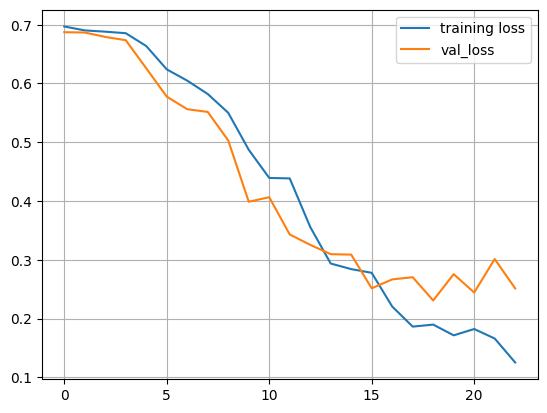

In [28]:
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.grid(True)
plt.legend()

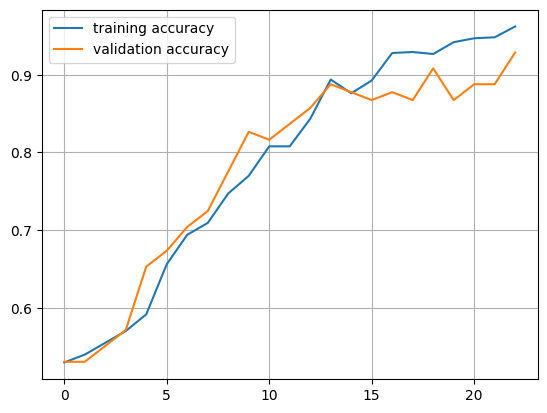

In [29]:
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [24]:
m.evaluate(training_ds)

25/25 [==============================] - 14s 562ms/step - loss: 0.0964 - accuracy: 0.9709


[0.09643526375293732, 0.9709228873252869]

In [25]:
m.evaluate(validation_ds)

4/4 [==============================] - 2s 389ms/step - loss: 0.2307 - accuracy: 0.9082


[0.23074930906295776, 0.9081632494926453]

In [26]:
m.evaluate(testing_ds)

4/4 [==============================] - 2s 419ms/step - loss: 0.2875 - accuracy: 0.8600


[0.2875371277332306, 0.8600000143051147]

The function below looks a bit complicated, but is a simple helper function which shows the image, the predicted class and the actual class for each image in the test dataset. Run it and have a look at how accurate the model seems and where it seems to be struggling.

In [ ]:
images, labels = testing_ds.next()

In [ ]:
images.shape

In [ ]:
y_pred = m.predict(images)

In [ ]:
labels = np.argmax(labels, axis = 1)

In [ ]:
class_names = list(class_names)

In [ ]:
y_pred = np.argmax(y_pred, axis = 1)

NameError: ignored

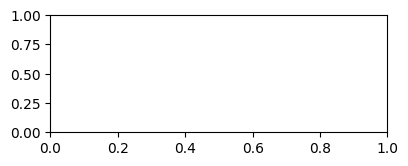

In [27]:
plt.figure(figsize = (20, 7))
for i in range(16):
  plt.subplot(4, 4, (i + 1))
  plt.imshow(np.reshape(images[i], (48, 48)), cmap = 'gray')
  plt.title('Pred: {} actl: {}'.format(class_names[y_pred[i]], class_names[labels[i]]))
plt.legend()

We can go ahead and view the models layers through the plot_model function below provided by keras for an intuitive view.

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(m, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

And thats all! We've successfully creating a model with an accuracy of around 90%. Notice that this can be further improved by performing image manipulation, performing pooling and training our model for a longer epoch or even adding more layers.. However, for our use case, this model we created is perfectly fine.  

# Testing Model on Videos  
In order to use our model on a video, which is our expected use case of a CCTV footage, we will have to use OpenCV in order get the individual frames.  
Lets define a function which takes in each frame and converts it into a tensor and then predicts the output class.

In [ ]:
def predict_frame(img):
    img_array = tf.keras.utils.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction=(model.predict(img_batch) > 0.5).astype("int32")
    if(prediction[0][0]==1):
        return("Accident Detected")
    else:
        return("No Accident")

The following code below makes use of OpenCV. Firstly, we read the video in and grab every 20th frame(in order to reduce total computation for this demonstration) and then we can resize the image and run our function on it.  
We'll store the label and the image in a list which we can easily access.

In [ ]:
import cv2
image=[]
label=[]

c=1
cap= cv2.VideoCapture('/kaggle/input/cctvfootagevideo/videoplayback (online-video-cutter.com).mp4')
while True:
    grabbed, frame = cap.read()
    if c%30==0:
        print(c)
        resized_frame=tf.keras.preprocessing.image.smart_resize(frame, (img_height, img_width), interpolation='bilinear')
        image.append(frame)
        label.append(predict_frame(resized_frame))
        if(len(image)==75):
            break
    c+=1

cap.release()

Lets see any random frame and see what the outcome is...

In [ ]:
print(label[74])
print(plt.imshow(image[74]))

Looks about right! There seems to be an accident occuring in this frame. Our model generalizes well and can be used for practical applications.